In [3]:
# ! pip install kagglehub numpy pandas tensorflow keras opencv-python matplotlib seaborn

In [4]:
import kagglehub
import shutil
import os
source_path = kagglehub.model_download("esfiam/pneumonia-detection-model/keras/v1.0")
destination_path = "./models/"
os.makedirs(destination_path, exist_ok=True)
shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

source_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
destination_path = "./data/"
os.makedirs(destination_path, exist_ok=True)
shutil.copytree(source_path, destination_path, dirs_exist_ok=True) # fix
print(f"Dataset saved to: {destination_path}")


%|          | 0.00/170M [00:00<?, ?B/s]
%|          | 1.00M/170M [00:00<00:29, 6.00MB/s]
%|▌         | 9.00M/170M [00:00<00:04, 40.5MB/s]
%|▊         | 14.0M/170M [00:00<00:04, 35.8MB/s]
%|█▎        | 22.0M/170M [00:00<00:03, 50.5MB/s]
%|█▊        | 30.0M/170M [00:00<00:02, 59.5MB/s]
%|██▏       | 37.0M/170M [00:00<00:02, 62.6MB/s]
%|██▋       | 46.0M/170M [00:00<00:01, 71.3MB/s]
%|███▏      | 54.0M/170M [00:01<00:01, 66.5MB/s]
%|███▊      | 65.0M/170M [00:01<00:01, 69.4MB/s]
%|████▏     | 72.0M/170M [00:01<00:01, 68.9MB/s]
%|████▉     | 83.0M/170M [00:01<00:01, 81.0MB/s]
%|█████▌    | 94.0M/170M [00:01<00:01, 79.3MB/s]
%|██████▏   | 105M/170M [00:01<00:00, 88.2MB/s] 
%|██████▋   | 114M/170M [00:01<00:00, 77.0MB/s]
%|███████▎  | 125M/170M [00:01<00:00, 85.2MB/s]
%|███████▉  | 134M/170M [00:02<00:00, 74.4MB/s]
%|████████▌ | 145M/170M [00:02<00:00, 83.9MB/s]
%|█████████▏| 156M/170M [00:02<00:00, 91.6MB/s]
100%|██████████| 170M/170M [00:02<00:00, 73.8MB/s]


100%|██████████| 2.29G/2.29G [00:22<00:00, 111MB/s] 

Extracting files...


Dataset saved to: ./data/


In [7]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
import cv2
from glob import glob
import matplotlib.pyplot as plt

model = load_model('./models/model_Pneumonia_detection.keras')

2025-03-08 23:33:39.181737: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
model.inputs # the input shape is None, 256, 256, 1;
# the input shape needs to be formatted to match the input batchsize, H, W, channels

[<KerasTensor shape=(None, 256, 256, 1), dtype=float32, sparse=False, ragged=False, name=input_layer_3>]

In [9]:
def img_setting(path):
    img = load_img(path, target_size=(256, 256), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

def mc_dropout_inference(img, nb_inference: int, model: Sequential) -> np.ndarray:
    return np.stack(
        [model({"input_layer_3": img}, training=True) for sample in range(nb_inference)], axis = -1
    )

def calculate_entropy(p):
    p = np.array(p)
    p = p[p > 0]
    return -np.sum(p * np.log2(p))

In [11]:
pneumonia_img_paths = glob("./data/chest_xray/test/PNEUMONIA/*.jpeg")
img = img_setting(pneumonia_img_paths[1])
img.shape # formatted compatable to the input shape palatable to the network

(1, 256, 256, 1)

### Model JailBreaking Experiments

## 1 Pixel Attack :
Change the value of just one pixel in the image to filp the predictions. Just one pixel and nothing else.

How Does One-Pixel Attack Work?
1. Select a single pixel in the input image.
2. Modify its RGB (or grayscale) value within a small range.
3. Use an optimization algorithm (e.g., Differential Evolution) to find the pixel modification that maximally changes the model's prediction.
4. Measure the change in confidence and uncertainty to understand adversarial effects.

**Differential evolution** is a stochastic population based method that is useful for global optimization problems. At each pass through the population the algorithm mutates each candidate solution by mixing with other candidate solutions to create a trial candidate.

In [5]:
from scipy.optimize import differential_evolution

def one_pixel_attack(img, model, pixel_count=1, bounds=(0, 1)):

    def evaluate_attack(pixels):
        perturbed = np.copy(img)
        for i in range(pixel_count):
            row, column, intensity = int(pixels[i*3]), int(pixels[i*3 + 1]), pixels[i*3 + 2]

            # batch, rows, columns, channel we have grayscale image so channel is 1, and the image is normalized
            perturbed[0, row, column, 0] = intensity  # Modify pixel

        # Get new prediction
        pred = model.predict(perturbed, verbose=0)[0][0]  # Probability of Pneumonia
        return pred  # Lower values = stronger attack

    # Define search bounds: (row, column, intensity) for each pixel
    # the bound is between (0, 1) because the pixel value is normalized (divide by 255)
    img_size = 256
    bounds = [(0, img_size), (0, img_size), bounds] * pixel_count


    result = differential_evolution(evaluate_attack, bounds, maxiter=20, popsize=10)

    # result has success attribute, and x which contains the result
    print(f"Attack :{result.success}")


    perturbed_img = np.copy(img)

    for i in range(pixel_count):
        x, y, intensity = int(result.x[i*3]), int(result.x[i*3+1]), result.x[i*3+2]
        perturbed_img[0, y, x, 0] = intensity  # Modify pixel

    return perturbed_img


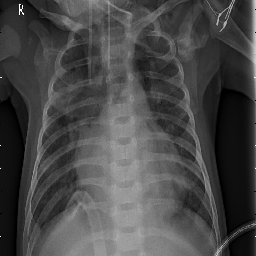

In [6]:
load_img(pneumonia_img_paths[0], target_size=(256, 256), color_mode='grayscale') # rows, columns

In [ ]:
adv_img = one_pixel_attack(img, model, pixel_count=1)
original_pred = model.predict(img, verbose=0)[0][0]
adv_pred = model.predict(adv_img, verbose=0)[0][0]
print(f'No attack prediction {original_pred:.4f}')
print(f'Attack Prediction {adv_pred:.4f}')

Attack :True
No attack prediction 0.9942
Attack Prediction 0.9942


## Interestingly the one pixel attack does not succeed.

### **Possible Reasons Why the Attack Didn’t Work**
1. **The Model is Too Robust**  
   - The model may have learned strong features that are not easily disrupted by a **single pixel change**.
   - Since X-ray images contain high-level medical patterns, the model may rely on **broader spatial structures** rather than isolated pixels.

2. **The Perturbation is Too Weak**  
   - The intensity change in grayscale images (0-1 range) might not be strong enough.

3. **The Model Has Strong Spatial Invariance**  
   - CNNs are typically robust to **local pixel changes** because they use convolutional filters that generalize features across regions.
   - A **single pixel modification** may not be enough to disrupt a global decision.

4. **The Pixel Selection Might Not Be Optimal**  
   - If the chosen pixel is **not important for the decision**, modifying it won’t have a major effect.

In [ ]:
# increasing pixel count to 100 does not work
# adv_img = one_pixel_attack(img, model, pixel_count=10)
# original_pred = model.predict(img, verbose=0)[0][0]
# adv_pred = model.predict(adv_img, verbose=0)[0][0]
# print(f'No attack prediction {original_pred:.4f}')
# print(f'Attack Prediction {adv_pred:.4f}')

### **FGSM(Fast Gradient Sign Method) Attack**
The Fast Gradient Sign Method (FGSM) modifies the input image in the direction of the gradient to maximize the loss.

FGSM is a gradient ascent attack on the loss function, pushing the image in a direction that maximally confuses the model. Let me know if you need further clarification!

#### **1. Compute the Loss Gradient**
- Compute how the **loss** changes with respect to the **input image**

#### **2. Generate Perturbation**
- Add a small perturbation **in the direction of the gradient sign**.
- The amount of perturbation is controlled by **ε (epsilon)**



No attack prediction 0.0398
Attack Prediction 0.0028


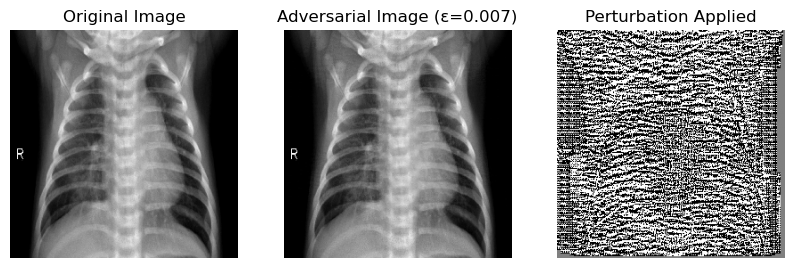

In [98]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def fgsm_attack(model, img, true_label, epsilon=0.007):
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    img_tensor = tf.Variable(img_tensor)  # Make it trainable

    # Compute loss within GradientTape
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)  # Track image for gradient computation
        prediction = model(img_tensor, training=False)
        true_label = tf.constant([[float(true_label)]], dtype=tf.float32)  # Convert to float tensor
        loss = tf.keras.losses.binary_crossentropy(true_label, prediction)

    gradient = tape.gradient(loss, img_tensor)
    signed_grad = tf.sign(gradient)

    # Apply perturbation to the original image
    adversarial_img = img + epsilon * signed_grad

    # Clip values to keep valid pixel range [0, 1]
    adversarial_img = tf.clip_by_value(adversarial_img, 0, 1)
    return adversarial_img, signed_grad, img_tensor


epsilon = 0.007
adv_img, perturbation, original_img = fgsm_attack(model, img, 1, epsilon)


plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(original_img[0, :, :, 0], cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(adv_img[0, :, :, 0], cmap="gray")
plt.title(f"Adversarial Image (ε={epsilon})")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(perturbation[0, :, :, 0], cmap="gray")
plt.title("Perturbation Applied")
plt.axis("off")

original_pred = model.predict(img, verbose=0)[0][0]
adv_pred = model.predict(adv_img, verbose=0)[0][0]
print(f'No attack prediction {original_pred:.4f}')
print(f'Attack Prediction {adv_pred:.4f}')

plt.show()

In [12]:
def extract_uncertainty_feature_maps(img, model, conv_layer_names, nb_inference=10):
    # Add the final layer name to conv_layer_names
    all_layer_names = conv_layer_names + ["dense_7"]

    # Define feature extractor model for multiple layers including final dense layer
    feature_extractor = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(name).output for name in all_layer_names]
    )

    # Repeat the input image `nb_inference` times to create a batch
    batch_imgs = np.repeat(img, nb_inference, axis=0)  # Shape: (10, 256, 256, 1)

    # Perform one forward pass with MC Dropout enabled
    feature_maps_batch = feature_extractor(batch_imgs, training=True)

    # Reshape feature maps: Convert from (10, H, W, C) to (H, W, C, 10)
    feature_maps = {
        layer_name: np.stack(np.split(feature_maps_batch[i], nb_inference, axis=0), axis=-1).squeeze(0)
        for i, layer_name in enumerate(all_layer_names)
    }

    entropy = calculate_entropy(feature_maps['dense_7'])
    # Compute mean and variance (uncertainty) across MC Dropout runs
    uncertainty_results = {
        layer_name: (np.mean(feature_maps[layer_name], axis=-1), np.var(feature_maps[layer_name], axis=-1))
        for layer_name in all_layer_names
    }

    avg_mu, avg_sigma = uncertainty_results['dense_7']
    del uncertainty_results['dense_7']

    return uncertainty_results, avg_mu, avg_sigma, entropy

# List of convolutional layers you want to analyze
conv_layers = ["conv2d_10", "conv2d_11", "conv2d_12"]  # Change based on your model

# Run the uncertainty heatmap overlay function'
feature_maps, avg_pred_mu, avg_pred_var, entropy = extract_uncertainty_feature_maps(img, model, conv_layers)
for k, (mu, sigma) in feature_maps.items():
    print(k, mu.shape, sigma.shape)

/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_3']
Received: inputs=Tensor(shape=(10, 256, 256, 1))
  warnings.warn(msg)


conv2d_10 (254, 254, 32) (254, 254, 32)
conv2d_11 (125, 125, 64) (125, 125, 64)
conv2d_12 (60, 60, 128) (60, 60, 128)


## **Step-by-Step Breakdown of Image Processing on the Feature Map**

### **1️⃣ Extracting the Feature Maps (Uncertainty Computation)**
After running MC Dropout, you extract feature maps from different layers.  
For each convolutional layer:  
- You compute the **mean feature map** (average activation).  
- You compute the **uncertainty map** (variance across multiple MC Dropout runs).  

🔹 **Issue Here:** The variance values are usually **very small** (e.g., in the range of `0.0001` to `0.01`). These small values don't map well to an image scale (0-255).  

---

### **2️⃣ Taking the Mean Across Channels**
```python
mean_uncer_map = np.mean(uncertainty_map, axis=-1)
```
- If the uncertainty map is **multi-channel** (e.g., `(H, W, C)`), this step collapses it into **a single-channel grayscale** uncertainty map of shape `(H, W)`.  
- **Effect:** Some spatial information is lost, but you now have a single uncertainty value per pixel.

---

### **3️⃣ Resizing to Match Input Image**
```python
uncertainty_map_resized = cv2.resize(mean_uncer_map, (256, 256), interpolation=cv2.INTER_LINEAR)
```
- **What Happens?**
  - If the original feature map is **smaller than (256, 256)**, this enlarges it.
  - If it’s **already 256×256**, this does nothing.
- **Effect:** Some pixel values might get interpolated, smoothing the uncertainty map.

🔹 **Potential Issue:** If feature maps are small (e.g., `60×60`), resizing **spreads out small values** over a larger image, making them even smaller.

---

### **4️⃣ Normalizing the Uncertainty Map**
```python
uncertainty_map_resized = cv2.normalize(uncertainty_map_resized, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
```
- **Why?** Feature values are originally **very small** (like `0.0001` to `0.01`), while image pixels need to be in the **0-255** range.
- **What Happens?**
  - The smallest uncertainty value is mapped to `0` (black).
  - The highest uncertainty value is mapped to `255` (white).
  - Everything else is **linearly scaled** between 0 and 255.

🔹 **Potential Issue:** If all values are **very close together**, normalization might not work well, making most pixels appear **the same color**.

---

### **5️⃣ Applying a Binary Threshold to Highlight Uncertainty**
```python
_, binary_mask = cv2.threshold(uncertainty_map_resized, threshold, 255, cv2.THRESH_BINARY)
```
- **What Happens?**
  - Any pixel **below `threshold`** → Set to `0` (black).
  - Any pixel **above `threshold`** → Set to `255` (white).
- **Effect:** This creates a **binary mask** where only high-uncertainty areas are white.

🔹 **Potential Issue:** If `threshold` is too **high**, almost everything might be `0`, and you won't see much in the heatmap.

---

### **6️⃣ Applying a Colormap (Jet Heatmap)**
```python
heatmap = cv2.applyColorMap(uncertainty_map_resized.astype(np.uint8), cv2.COLORMAP_JET)
```
- **What Happens?**
  - The grayscale uncertainty map is converted into a **color heatmap**.
  - **High uncertainty** (closer to `255`) → **Red or yellow**.
  - **Low uncertainty** (closer to `0`) → **Blue or dark colors**.

🔹 **Potential Issue:** If most values are small and normalization didn't work well, everything might get mapped to **one color (e.g., red or blue)**.

---

### **7️⃣ Masking the Heatmap with High-Uncertainty Areas**
```python
masked_heatmap = cv2.bitwise_and(heatmap, binary_mask_colored)
```
- This step ensures that **only the high-uncertainty pixels** (where `binary_mask` is `255`) are kept in the final heatmap.

🔹 **Potential Issue:** If `binary_mask` is mostly black, the entire heatmap gets masked out.

---

### **8️⃣ Blending the Heatmap with the Original Image**
```python
blended_image = cv2.addWeighted(img_rgb, 1 - mixing_alpha, masked_heatmap, mixing_alpha, 0)
```
- **What Happens?**
  - The **original X-ray image** is blended with the **heatmap**.
  - `mixing_alpha` controls how much of the **heatmap vs. X-ray** is visible.
  - **Higher alpha** = more heatmap, **lower alpha** = more X-ray.

🔹 **Potential Issue:** If `mixing_alpha` is too **high**, the heatmap might overpower the X-ray, making the image look mostly red.

---

## **Why Does Everything Look Red?**
Now that we understand the steps, here’s why your heatmap might look **entirely red**:

🔴 **Problem: Small Feature Values**  
✔️ **Fix:** Before normalization, try scaling uncertainty values:
```python
uncertainty_map_resized *= 100  # Scale up small values
```

🔴 **Problem: Normalization Failure (All Values Close Together)**  
✔️ **Fix:** Check the min/max values before normalization:
```python
print("Uncertainty Map Min:", uncertainty_map_resized.min())
print("Uncertainty Map Max:", uncertainty_map_resized.max())
```
If `max ≈ min`, normalization won’t work well.

🔴 **Problem: Threshold is Too High (Masking Out Everything)**  
✔️ **Fix:** Lower the threshold:
```python
threshold = 5  # Start low and increase gradually
```

🔴 **Problem: Colormap Saturation (Mapping Everything to Red)**  
✔️ **Fix:** Try another colormap:
```python
heatmap = cv2.applyColorMap(uncertainty_map_resized.astype(np.uint8), cv2.COLORMAP_VIRIDIS)
```
`COLORMAP_VIRIDIS` gives better contrast.

---

In [61]:
def overlay_uncertainty_heatmap(img, model, conv_layer_names, nb_inference=10, threshold=10, mixing_alpha=0.6):


    # Extract uncertainty feature maps for multiple layers
    uncertainty_results, avg_pred_mu, avg_pred_var, entropy = extract_uncertainty_feature_maps(img, model, conv_layer_names, nb_inference)

    # Convert grayscale image to RGB
    img_rgb = cv2.cvtColor(img.reshape(256, 256), cv2.COLOR_GRAY2RGB)
    img_rgb = (img_rgb * 255).astype(np.uint8)

    # Plot original image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(conv_layer_names) + 1, 1)
    plt.imshow(img.reshape(256, 256), cmap="gray")
    plt.title("Original X-ray")
    plt.axis("off")

    # Iterate over each layer and plot its uncertainty heatmap
    for i, (layer_name, (mean_feature_map, uncertainty_map)) in enumerate(uncertainty_results.items()):

       # Compute mean uncertainty across channels
        mean_uncer_map = np.mean(uncertainty_map, axis=-1)


        # Resize the uncertainty map to match the image size
        uncertainty_map_resized = cv2.resize(mean_uncer_map, (256, 256), interpolation=cv2.INTER_LINEAR)


        # Normalize to range 0-255
        uncertainty_map_resized = cv2.normalize(uncertainty_map_resized, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

        # Thresholding to isolate high-uncertainty areas
        _, binary_mask = cv2.threshold(uncertainty_map_resized, threshold, 255, cv2.THRESH_BINARY)
        # binary_mask = np.ones_like(uncertainty_map_resized) * 255
        binary_mask_colored = cv2.merge([binary_mask, binary_mask, binary_mask]).astype(np.uint8)

        # Apply colormap to create a heatmap
        heatmap = cv2.applyColorMap(uncertainty_map_resized.astype(np.uint8), cv2.COLORMAP_JET)

        # Mask heatmap with high-uncertainty areas
        masked_heatmap = cv2.bitwise_and(heatmap, binary_mask_colored)

        img_rgb = cv2.cvtColor(img.reshape(256, 256), cv2.COLOR_GRAY2RGB)
        img_rgb = (img_rgb * 255).astype(np.uint8)

        # Blend heatmap with original image
        blended_image = cv2.addWeighted(img_rgb, 1 - mixing_alpha, masked_heatmap, mixing_alpha, 0)

        # Plot heatmap overlay
        plt.subplot(1, len(conv_layer_names) + 1, i + 2)
        plt.imshow(blended_image)
        plt.title(f"Uncertainty - {layer_name}")
        plt.axis("off")

    plt.show()
    print(f'PRED INTERVAL: {avg_pred_mu - avg_pred_var}, {avg_pred_mu + avg_pred_var}; ENTROPY: {entropy / nb_inference:.4}')

overlay_uncertainty_heatmap(
    img_setting(pneumonia_img_paths[11]),
    model,
    conv_layers,
    # ["conv2d_12"],
    nb_inference=50,
    threshold=10,
    mixing_alpha=0.2
)

PRED INTERVAL: [0.81399536], [0.8332343]; ENTROPY: 0.2218


## Checking the spatial uncertainty with adversarial input

In [17]:
img.shape

(1, 256, 256, 1)

In [11]:
np.array(original_img).shape

(1, 256, 256, 1)

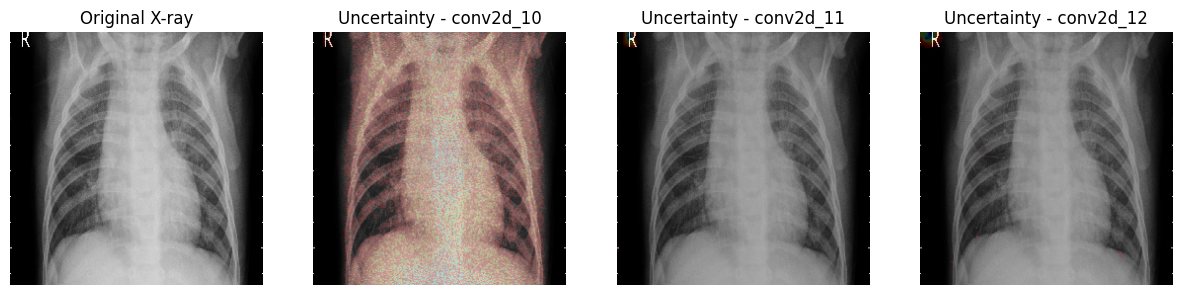

PRED INTERVAL: [0.9893487], [0.9896404]; ENTROPY: 0.01497


In [18]:
overlay_uncertainty_heatmap(
    np.array(original_img),
    model,
    conv_layers,
    nb_inference=50,
    threshold=10,
    mixing_alpha=0.2
)

In [19]:
overlay_uncertainty_heatmap(
    np.array(adv_img),
    model,
    conv_layers,
    nb_inference=50,
    threshold=10,
    mixing_alpha=0.2
)

PRED INTERVAL: [0.10986602], [0.12130184]; ENTROPY: 0.3266


The model probability about the image flips when the gradient is reduced even further at episilon = 0.05. We can see that there are some area where there is some spatial uncertainty, but overall the model seems certain that the image is normal one, rather than a pneumonia image. The change in the image is not visible to the human eye, so it is still possible to detect pneumonia, though the model is fooled into thinking that this image is a normal image. This highlights the vulnerability of the the image classification models. Though they may be robust to minor attacks since they aggregate their finding through several layers before giving their decisions. Something that is rather indistinguishable to humans can cause the network to become overconfident in its predictions. This is visible in the uncertainty heat map, however the entropy measure fails here. So both of them needs to be assessed in conjunction, because the spatial uncertainty might still be low because the attack has been on parts of the image that are not important in decision, but at the same time the uncertainty measure increases sharply. (We need to plot the uncertainty measure across the confusion matrix, and see the distribution, boxplot to understand what is going on, and if we can use this measure).


In [29]:
epsilon = 0.02
adv_img, perturbation, original_img = fgsm_attack(model, img, 1, epsilon)
overlay_uncertainty_heatmap(
    np.array(adv_img),
    model,
    conv_layers,
    nb_inference=50,
    threshold=10,
    mixing_alpha=0.2
)

PRED INTERVAL: [0.01853033], [0.01973908]; ENTROPY: 0.0943


Entropy Measure across all the predictions
Plot the distribution of the Entropy Measure across the confusion matrix, and see if it on average helps us identify between reliable and unreliable predictions. I think that we can even train a separate model using this entropy measure and the spatial uncertainty estimates to flag out unreliable predictions.

In [74]:
# get predictions on all the images and the entropy measure
normal_test_cases_path = glob("./data/chest_xray/test/NORMAL/*.jpeg")
pneumonia_test_cases_path = glob("./data/chest_xray/test/PNEUMONIA/*.jpeg")

mean_pred = []
entropy = []
conv_layer = ["conv2d_12"]
for path in pneumonia_test_cases_path:
    img = img_setting(path)
    _, avg_pred_mu, avg_pred_var, entr = extract_uncertainty_feature_maps(
        img, model, conv_layer, 100
    )
    mean_pred.append(avg_pred_mu[0])
    entropy.append(entr)

/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_3']
Received: inputs=Tensor(shape=(100, 256, 256, 1))
  warnings.warn(msg)


In [77]:
with open('./entropy.npy', 'wb') as f:
    np.save(f, np.array(entropy))

with open('./avg_pred.npy', 'wb') as f:
    np.save(f, np.array(mean_pred))

# with open('./entropy.npy', 'rb') as f:
#     entropy = np.load(f)

# with open('./avg_pred.npy', 'rb') as f:
#     mean_pred = np.load(f)



In [81]:
import pandas as pd
import seaborn as sns
pred_threshold = 0.5
results = pd.DataFrame({'mean_pred':mean_pred, 'entropy': entropy})
results['pred_condition'] = results.mean_pred.apply(lambda x: 'PNEUMONIA' if x > pred_threshold else 'NORMAL')
results.head()

mean_pred    entropy pred_condition
0   0.738742  30.315784      PNEUMONIA
1   0.551520  45.683487      PNEUMONIA
2   0.997967   0.292254      PNEUMONIA
3   0.992941   1.000659      PNEUMONIA
4   0.994330   0.812056      PNEUMONIA

In [82]:
results.value_counts('pred_condition')

pred_condition
PNEUMONIA    366
NORMAL        24
Name: count, dtype: int64

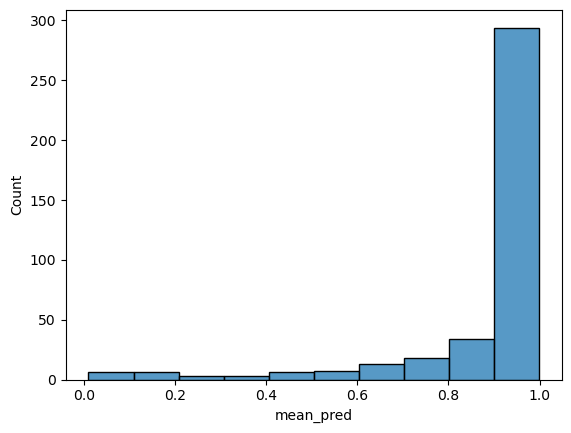

In [83]:
# look at the spread in the predictions
_ = sns.histplot(x='mean_pred', data=results, binwidth=0.1)

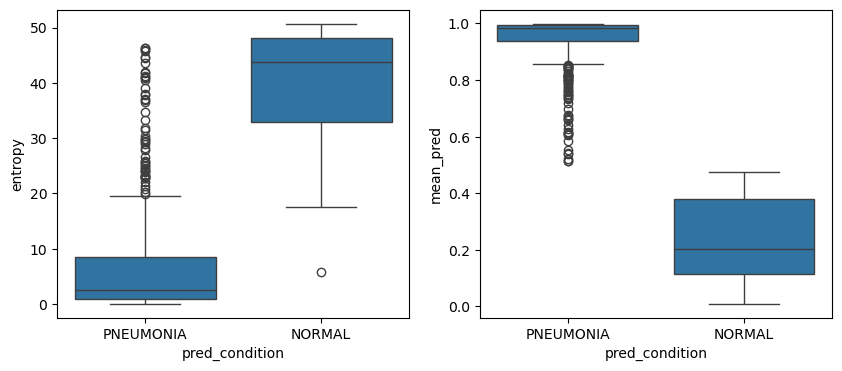

In [84]:
# boxplot entropy according to predictions.
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
_ = sns.boxplot(x='pred_condition', y='entropy', data=results, ax=ax[0])
_ = sns.boxplot(x='pred_condition', y='mean_pred', data=results, ax=ax[1])

In [86]:
# how about prediction in the network without MC dropout, how does that look

# no_dropout_pred = []
# for path in pneumonia_img_paths:
#     img = img_setting(path)
#     pred = model.predict(img, verbose=False)[0][0]
#     no_dropout_pred.append(pred)

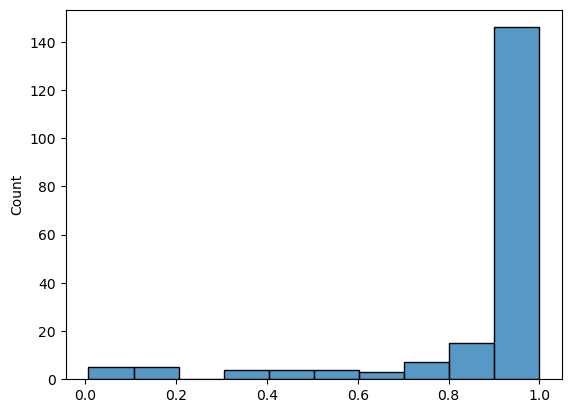

In [87]:
_ = sns.histplot(pd.Series(no_dropout_pred), binwidth=0.1)

We notice here that there is a huge variation in the prediction generated for the true positive cases, and if we naively set the threshold to 0.5 then we are bound to misclassify several cases. What can be done ? We check for the spatial uncertainty for those cases that are not certain. Let us check for those that were misclassified that is pred < 0.5 How does the image uncertainty looks like in the most several cases that is where the model is absolutely sure of its prediction 0 < pred <= 0.1 . It is 90% sure that it is a normal image, those are the cases we need to track and check.


In case there is no spatial uncertainty, try FGSM attack with a small perturbation, and check the estimate is still robust or not. If we can make the prediction uncertain with a small perturbation, they adversarial training might help. We can train the network using a set of perturbed images, to enhance the predictions.

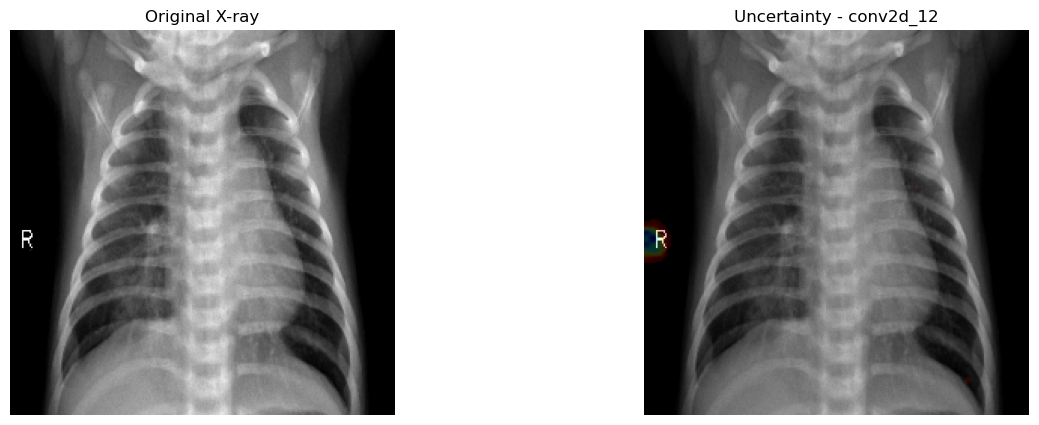

PRED INTERVAL: [0.05002659], [0.0535499]; ENTROPY: 0.2002


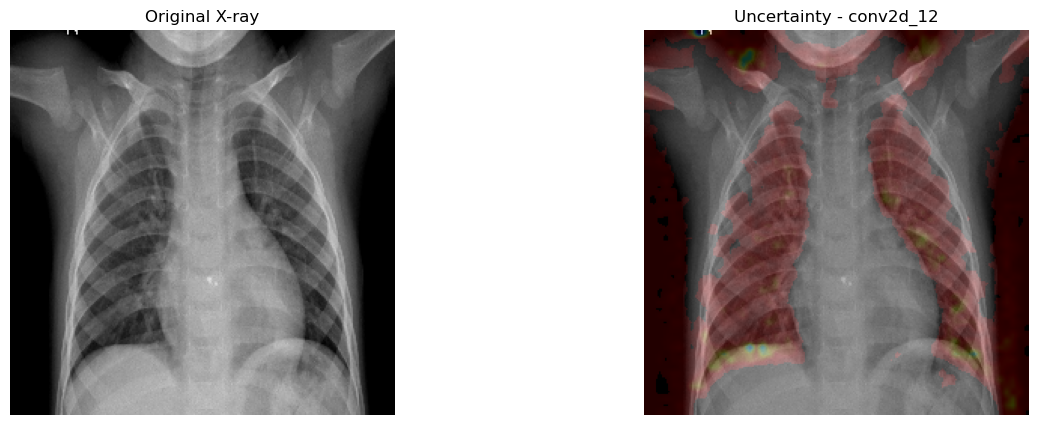

PRED INTERVAL: [0.07462023], [0.07829648]; ENTROPY: 0.2682


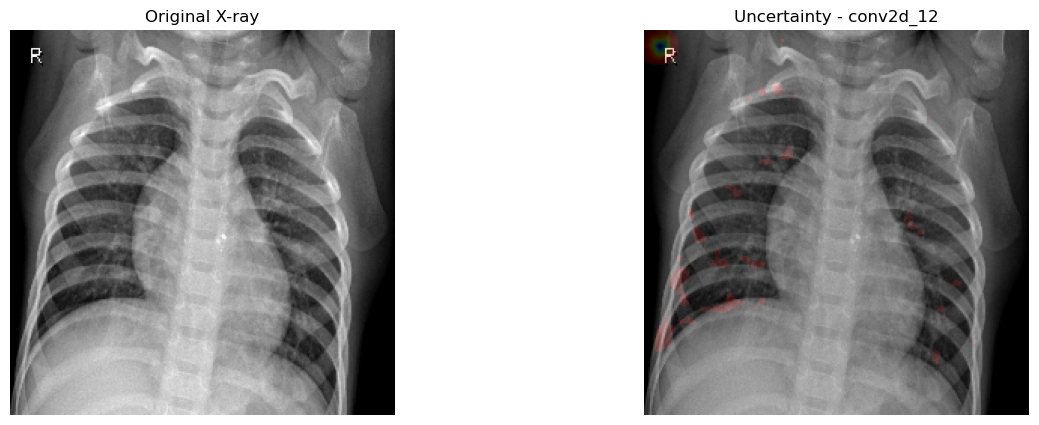

PRED INTERVAL: [0.0135203], [0.01437743]; ENTROPY: 0.07282


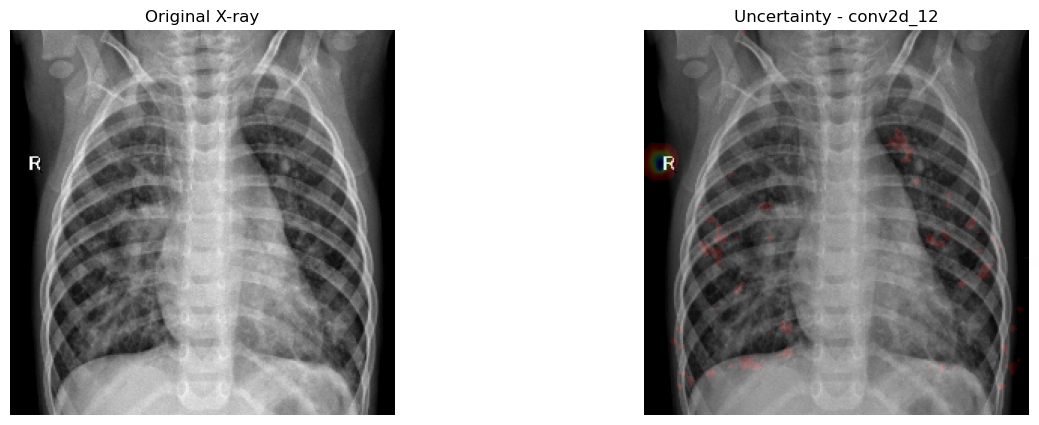

PRED INTERVAL: [0.0982307], [0.10503215]; ENTROPY: 0.3132


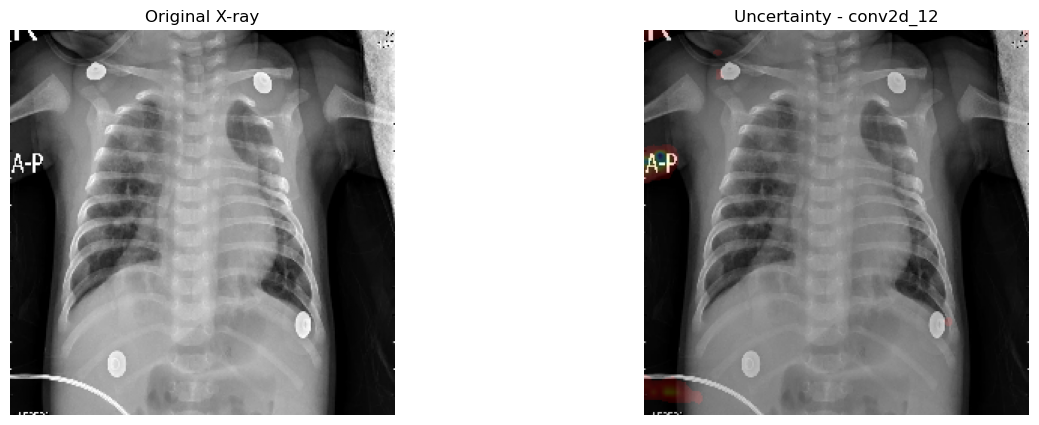

PRED INTERVAL: [0.06851553], [0.07506726]; ENTROPY: 0.2453


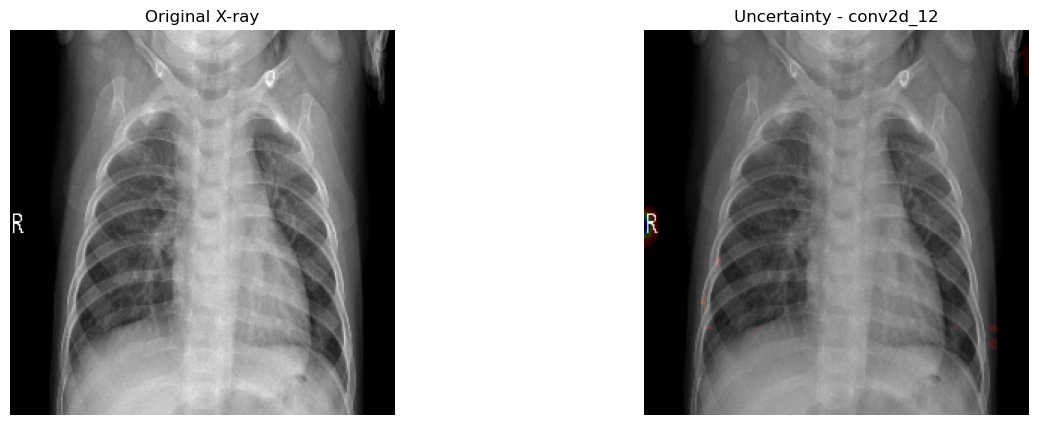

PRED INTERVAL: [0.06557361], [0.07060105]; ENTROPY: 0.2415


In [95]:
results['high_conf_false_negative'] = results.mean_pred <= 0.1


# check for feature map uncertainty in the images that were confidently predicted as being normal
false_neg_index = results.loc[results.high_conf_false_negative].index

conv_layer = ["conv2d_12"]
for i in false_neg_index:
    img = img_setting(pneumonia_test_cases_path[i])
    overlay_uncertainty_heatmap(
    img,
    model,
    ["conv2d_12"],
    nb_inference=100,
    threshold=10,
    mixing_alpha=0.2
)

### Observations
We can see that in only one of the cases the entropy measure was very low, and it most of the cases despite the model being sure about its prediction, the entropy was high enough for us to reconsider the decision given by the model.

And in most of the cases there was no spatial uncertainty. This means the the average prediction might be correlated with the spatial uncertainity. If there is not spatial uncertainty the model is quite sure about its output. Yet the entropy measure increases despite the seemly small variation. Or may be this might all be just by chance.

### Checking the same input with aversarial version of the image.

perturb the image slightly and watch if the model wobbles and flails

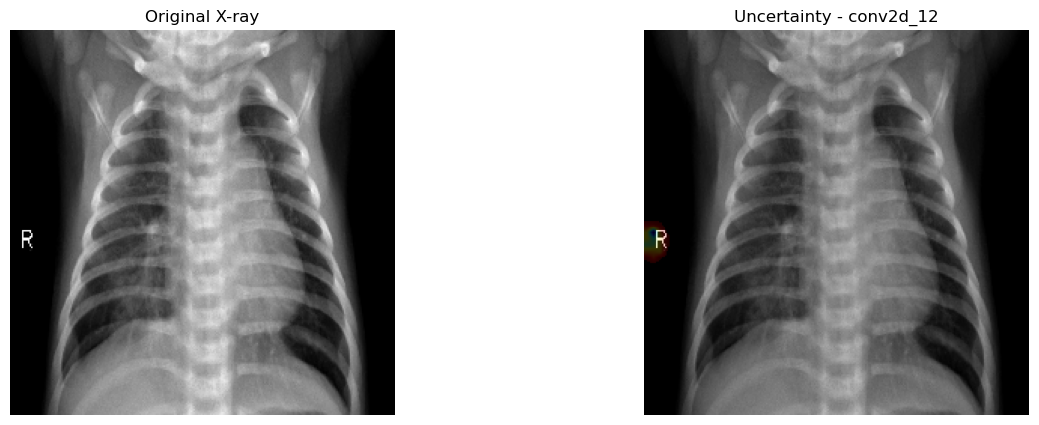

PRED INTERVAL: [0.0294286], [0.03054644]; ENTROPY: 0.1407


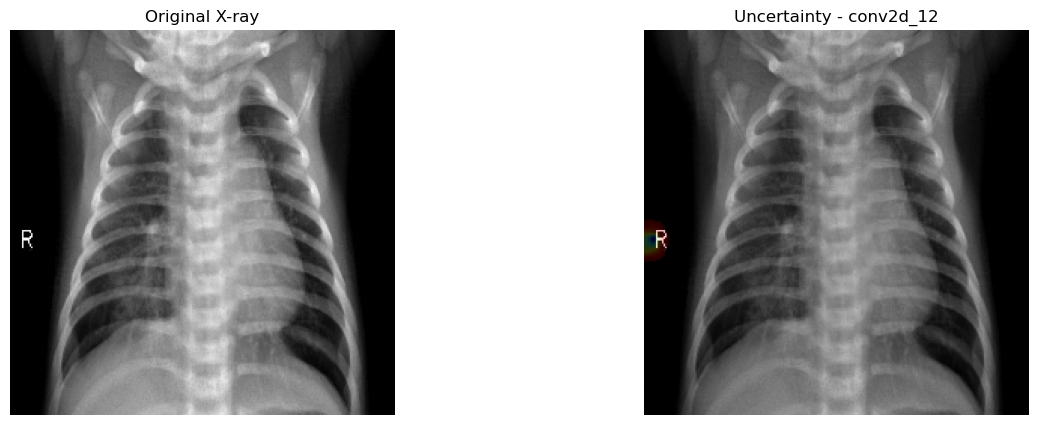

PRED INTERVAL: [0.00919018], [0.00965917]; ENTROPY: 0.05513


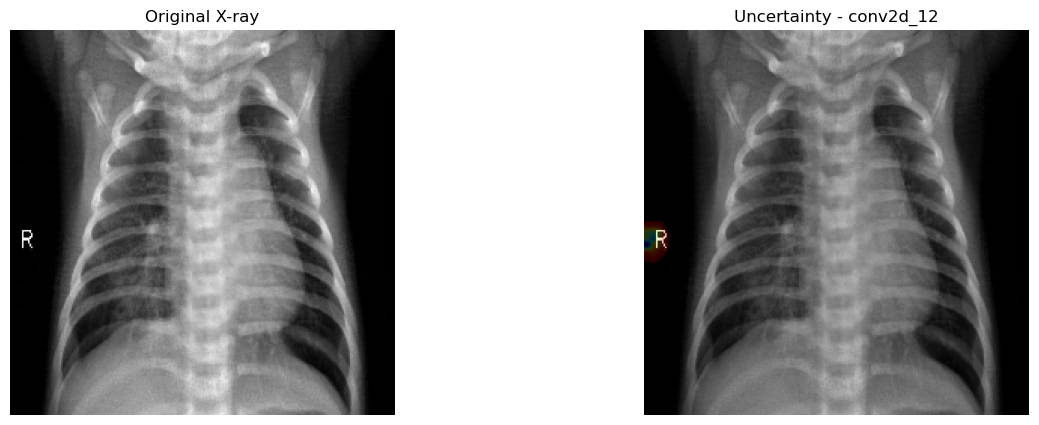

PRED INTERVAL: [0.00259714], [0.00262047]; ENTROPY: 0.0201


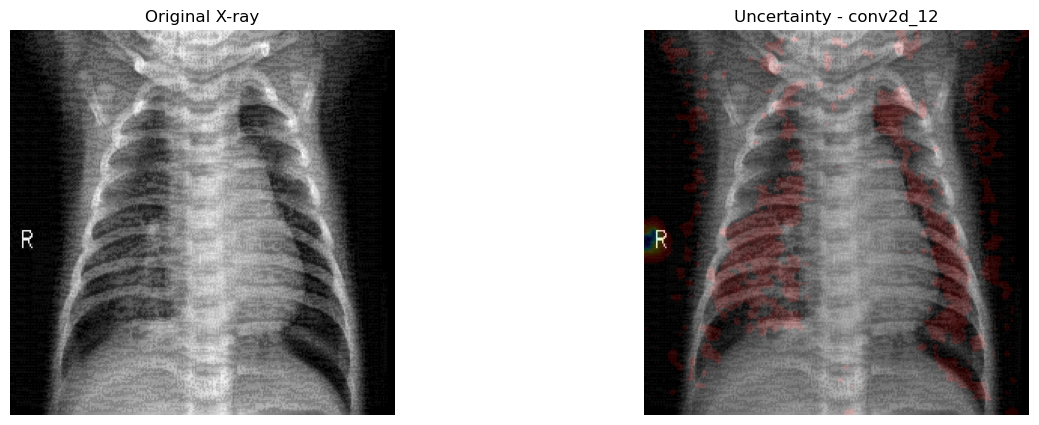

PRED INTERVAL: [0.00016545], [0.00016586]; ENTROPY: 0.001719


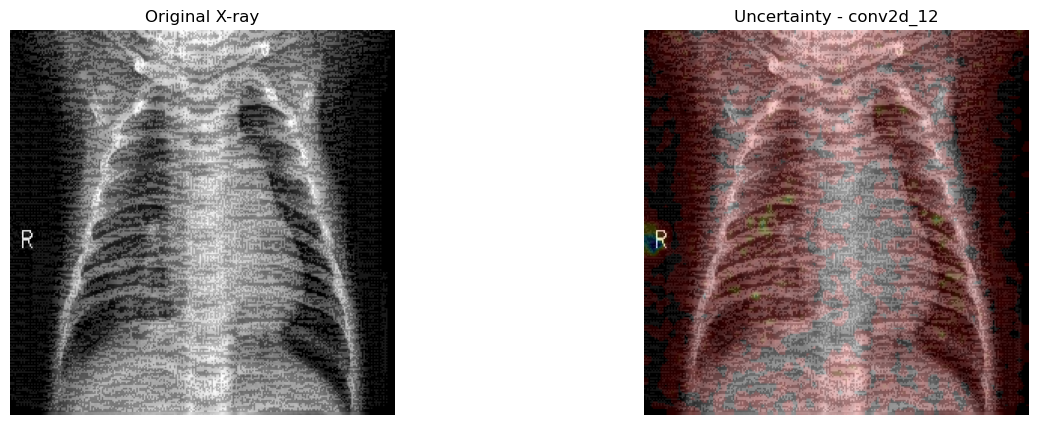

PRED INTERVAL: [1.7445042e-05], [1.7468841e-05]; ENTROPY: 0.0002039


In [104]:
conv_layer = ["conv2d_12"]
for eps in [0.001, 0.005, 0.01, 0.05, 0.1]:
    for i in false_neg_index[:1]:
        img = img_setting(pneumonia_test_cases_path[i])
        adv_img, perturbation, original_img = fgsm_attack(model, img, true_label=1, epsilon=eps)
        overlay_uncertainty_heatmap(
        np.array(adv_img),
        model,
        ["conv2d_12"],
        nb_inference=100,
        threshold=10,
        mixing_alpha=0.2
    )

# Observation

Interestingly, as we increase the uncertainty in the image, the model becomes more and more certain that the image is not pnemonia, but that conversly mean that the image predicts that the image is normal !!! 

the problem is with interpretation, where we cannot interpret the non-pnemonia image as normal image, which is not correct.